## 1) Introduction

This simple notebook implements the mathematical forward models whose descriptions can be found [in this document](https://www.overleaf.com/project/623dc6078b3a6b1b29dfcc5a) (needs to be invited).

In [1]:
# The modules to import
from scipy.signal import convolve2d

from input_initialization import *
from tool_box import *
from custom_convolution import *

## 2) Input setup

Concerning the dimensions, like in the document we have :
* `N_i` the amount of pixels in a column;
* `N_j` the amount of pixels in a row;
* `N_ij` the product of `N_i` and `N_j`;
* `N_k` the amount of channels;
* `N_ijk` the product of `N_ij` and `N_k`.

We retreive the input scene from a netCDF4 file and put it in the 3 dimensional matrix `Ux`, corresponding to the $\boldsymbol{U^{[x]}}$ matrix in the document.

Then we instanciate the matrix `X`, which is `Ux` whose 2nd space dimension is flattened (corresponding to $\boldsymbol{X}$). We also flatten `X` into `x`.

Finally we get the `spectral_stencil`, the ordered array of the sampled wavelengths (in Ångström).

We define also a second pair of data, much smaller to be printed.

In [2]:
# We decide get the input and its spectral stencil
Ux, spectral_stencil = initialize_input('tarkus')

# Declaration of the dimensions
N_i, N_j, N_k = Ux.shape
N_ij = N_i * N_j
N_ijk = N_ij * N_k

# Declaration of X
X = np.zeros((N_ij, N_k))

for k in range(N_k):
    X[:, k] = Ux[:, :, k].flatten('F')

# Declaration of x
x = X.flatten('F')

# I) Forward model

The aim of this part is to model the effects of three operations (CFA, binning and sub-sampling) on an input $\boldsymbol{x}$.

## I.1) Mask creation

In this part we declare `k_r`, `k_g` and `k_b`, the indices of the colors red, green and blue in the spectral stencil.

Then we construct the 3 dimensional matrices `UBayer` and `UQuad`. They are the implementation of the Bayer CFA and the Quad-Bayer CFA.

See $\boldsymbol{U^{[Bayer]}}$ and $\boldsymbol{U^{[Quad]}}$ in the document for more informations.

Like for `X`, we introduce `HBayer` and `HQuad`, the flatened versions of `UBayer` and `UQuad`.

We compute the two mask matrices with those expressions :

$$
\mathcal{U}^{[Bayer]}_{i, j, k} =
\left\{
\begin{array}{lll}
    1 & \text{if $k = k_r$ and} & \text{$i \bmod{2} = 0$ and $j \bmod{2} = 1$}\\
    1 & \text{if $k = k_g$ and} & \text{(($i \bmod{2} = 0$ and $j \bmod{2} = 0$) or}\\
    && \text{($i \bmod{2} = 1$ and $j \bmod{2} = 1$))}\\
    1 & \text{if $k = k_b$ and} & \text{$i \bmod{2} = 1$ and $j \bmod{2} = 0$}\\
    0 & \text{otherwise}
\end{array}
\right.

\text{and} \quad

\mathcal{U}^{[Quad]}_{i, j, k} =
\left\{
\begin{array}{lll}
    1 & \text{if $k = k_r$ and} & \text{$i \bmod{4} < 2$ and $j \bmod{4} \geq 2$}\\
    1 & \text{if $k = k_g$ and} & \text{(($i \bmod{4} < 2$ and $j \bmod{4} < 2$) or}\\
    && \text{($i \bmod{4} \geq 2$ and $j \bmod{4} \geq 2$))}\\
    1 & \text{if $k = k_b$ and} & \text{$i \bmod{4} \geq 2$ and $j \bmod{4} < 2$}\\
    0 & \text{otherwise}
\end{array}
\right.
$$

Finally we compute the matrices `ABayer` and `AQuad` that encode the operation.

In [3]:
# Declaration of the indices of the wavelength of the red, green and blue colors
k_r = (np.abs(spectral_stencil - 6500)).argmin()
k_g = (np.abs(spectral_stencil - 5500)).argmin()
k_b = (np.abs(spectral_stencil - 4450)).argmin()

# Declaration of UBayer and UQuad
UBayer = np.zeros_like(Ux)
UQuad = np.zeros_like(Ux)

for i in range(N_i):
    for j in range(N_j):
        for k in range(N_k):
            if k == k_r:
                if i % 2 == 0 and j % 2 == 1:
                    UBayer[i, j, k] = 1

                if i % 4 < 2 and j % 4 >= 2:
                    UQuad[i, j, k] = 1

            elif k == k_g:
                if (i % 2 == 0 and j % 2 == 0) or (i % 2 == 1 and j % 2 == 1):
                    UBayer[i, j, k] = 1

                if (i % 4 < 2 and j % 4 < 2) or (i % 4 >= 2 and j % 4 >= 2):
                    UQuad[i, j, k] = 1

            elif k == k_b:
                if i % 2 == 1 and j % 2 == 0:
                    UBayer[i, j, k] = 1

                if i % 4 >= 2 and j % 4 < 2:
                    UQuad[i, j, k] = 1

# Declaration of the flattened mask matrices
HBayer = np.zeros((N_ij, N_k))
HQuad = np.zeros((N_ij, N_k))

for k in range(N_k):
    HBayer[:, k] = UBayer[:, :, k].flatten('F')
    HQuad[:, k] = UQuad[:, :, k].flatten('F')

## I.2) Performing the CFA's operation

We use the formula :

$$
    \boldsymbol{y} = \sum_{k = 1}^{N_k} \boldsymbol{X_{:k}} \odot \boldsymbol{H_{:k}}
$$

Or directly :

$$
    \boldsymbol{y} = \boldsymbol{A^{CFA}} \boldsymbol{x}
$$

Where $\boldsymbol{y}$ is a vector of $\mathbb{R}^{N_{ij}}$.

In [4]:
# Results of the masks
yBayer = sum(X[:, k] * HBayer[:, k] for k in range(N_k))
yQuad = sum(X[:, k] * HQuad[:, k] for k in range(N_k))

# Un-flatten the results
YBayer = np.reshape(yBayer, (N_i, N_j), order='F')
YQuad = np.reshape(yQuad, (N_i, N_j), order='F')

## I.3) Binning matrix creation

In this part we define the matrix `B` to match the pattern of the Quad-Bayer CFA. This matrix will guide the computations during the binning (see the matrix $\boldsymbol{B}$ in the document).

In [5]:
# Construcion of the matrix B
B = np.zeros((N_i, N_j))

for i in range(N_i):
    for j in range(N_j):
        if i % 2 == 0 and j % 2 == 0:
            B[i, j] = 2

## I.4) Performing the binning

The operation is done by filling the output $\boldsymbol{Y^{bin}}$ aggregated squares by aggregated squares.

We use the formula stating that $\forall (i, j) \in \{0, ..., N_{i} - 1\} \times \{0, ..., N_{j} - 1\}$ such that $B_{i, j} = l \ne 0$ we have :

$$
    \boldsymbol{Y^{bin}_{i:i + l - 1, j:j + l - 1}} = \mathcal{A}(\boldsymbol{Y}, i, j, l)
$$

In [6]:
# Result of the binning
Ybin = np.zeros((N_i, N_j))

for i in range(N_i):
    for j in range(N_j):
        l = int(B[i, j])
        if l != 0:
            l_i = ((i + l) >= N_i) * (N_i - i - l) + l
            l_j = ((j + l) >= N_j) * (N_j - j - l) + l
            
            mean_value = np.mean(YQuad[i:i + l_i, j:j + l_j])

            for ii in range(l_i):
                for jj in range(l_j):
                    Ybin[i + ii, j + jj] = mean_value

## I.5) Performing the sub-sampling

We get `l_GCD` the greatest common divisor of all the lengths of the aggregated squares. We take every $l_{GCD}$-th value of the matrix $\boldsymbol{Y^{bin}}$ and put them in the output $\boldsymbol{Y^{sub}}$.


The size of $\boldsymbol{Y^{sub}}$ is $P_i \times P_j$, with $P_i = \left\lceil \dfrac{N_i}{l_{GCD}} \right\rceil$ and $P_j = \left\lceil \dfrac{N_j}{l_{GCD}} \right\rceil$.

In [7]:
# Computation of the GCD of the lengths
l_GCD = np.gcd.reduce(B.reshape(N_i * N_j).astype('int32'))

# Computation of the output size
P_i, P_j = int(np.ceil(N_i / l_GCD)), int(np.ceil(N_j / l_GCD))
P_ij = P_i * P_j

# Result of the sub-sampling
Ysub = np.zeros((P_i, P_j))

for i in range(P_i):
    for j in range(P_j):
        Ysub[i, j] = Ybin[i * l_GCD, j * l_GCD]

## I.6) Visualization

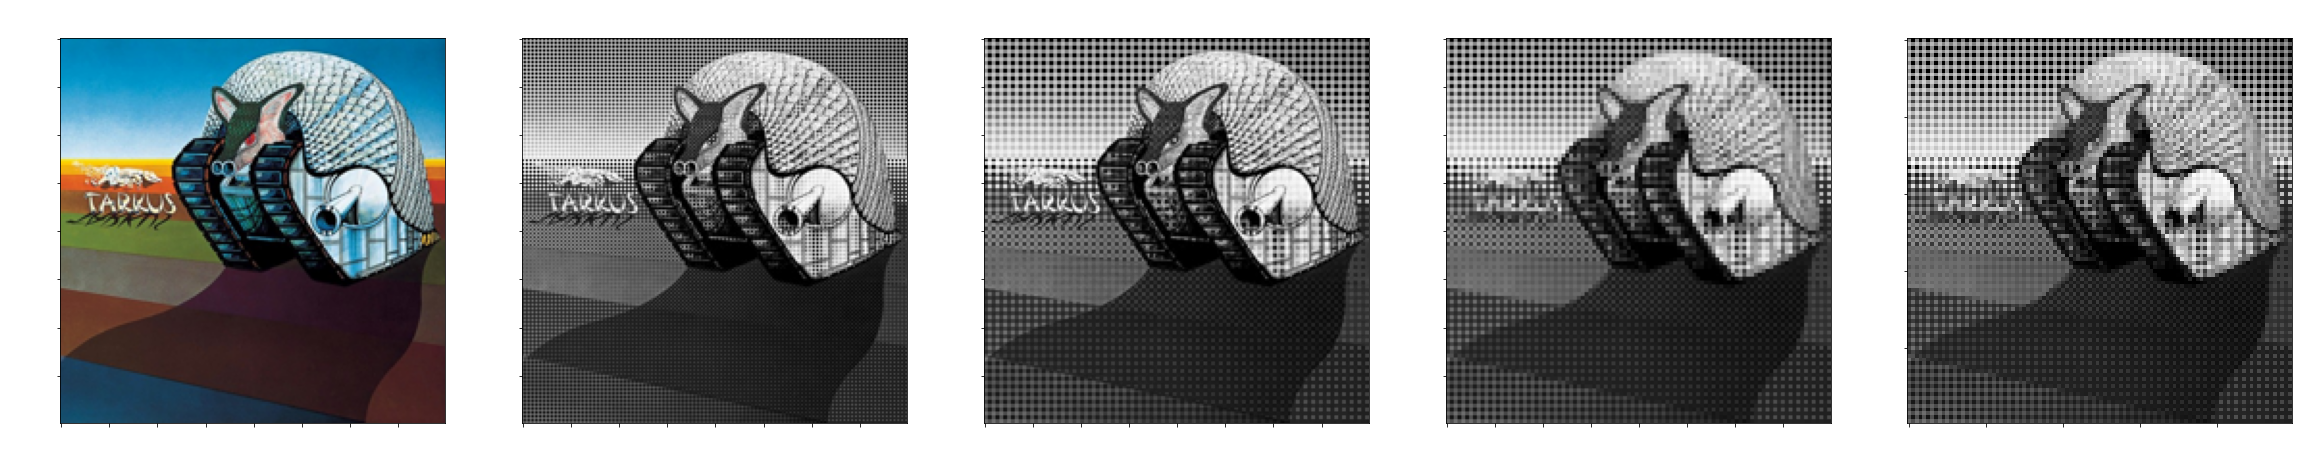

In [8]:
plot_images([Ux, YBayer, YQuad, Ybin, Ysub], ['The input image Ux', 'Output Bayer CFA YBayer', 'Output Quad-Bayer CFA YQuad', 'Output binning Ybin', 'Output sub-sampling Ysub'])

# II) Inverse model

In the following part of the notebook we implement the inverse model. Its goal is to start from $\boldsymbol{y}$ (which is the final output, usually $\boldsymbol{y^{sub}}$) and the knowledge of the performed operations, and to end with a plausible input $\boldsymbol{\hat{x}}$ that is as close as possible from $\boldsymbol{x}$.

## II.1) Upscaling

We create $\boldsymbol{Y^{up}}$ the upscaled version of the final output $\boldsymbol{Y}$ which is of size $P_i \times P_j$.

The matrix $\boldsymbol{Y^{up}}$ will then be of the size $N_i \times N_j$, which is the original size of the input/output. 

In [9]:
# Creation of Yup
Yup = np.zeros((N_i, N_j))

for i in range(P_i):
    for j in range(P_j):
        Yup[i * l_GCD:(i + 1) * l_GCD, j * l_GCD:(j + 1) * l_GCD] = Ysub[i, j]

## II.2) Demosaicing

We proceed on two steps, we create the sparse reconstruction `Ux_hat` by placing in the right channel each of the output `Y` according to the filter given be the CFA.

Then we apply the following kernels to their corresponding channels (0 is red, 1 is green and 2 is blue). In the case of a Bayer CFA we use :

$$
    \boldsymbol{K^{Bayer}_{red/blue}} = \dfrac{1}{4}
    \left[ {\begin{array}{ccc}
        1 & 2 & 1\\
        2 & 4 & 2\\
        1 & 2 & 1
    \end{array} }\right]
    \quad
    \boldsymbol{K^{Bayer}_{green}} = \dfrac{1}{4}
    \left[ {\begin{array}{ccc}
        0 & 1 & 0\\
        1 & 4 & 1\\
        0 & 1 & 0
    \end{array} }\right]
$$

And in the case of a Quad-Bayer CFA we use :

$$
    \boldsymbol{K^{Quad}_{red/blue}} = \dfrac{1}{6}
    \left[ {\begin{array}{ccccc}
        0 & 1 & 0 & 1 & 0\\
        1 & 2 & 2 & 2 & 1\\
        0 & 2 & 0 & 2 & 0\\
        1 & 2 & 2 & 2 & 1\\
        0 & 1 & 0 & 1 & 0
    \end{array} }\right]
    \quad
    \boldsymbol{K^{Quad}_{green}} = \dfrac{1}{2}
    \left[ {\begin{array}{ccc}
        0 & 1 & 0\\
        1 & 0 & 1\\
        0 & 1 & 0
    \end{array} }\right]
$$

In [10]:
def demosaicking(Y, pattern='Bayer'):
    # Declaration of the kernels
    if pattern == 'Bayer':
        ker_red_blue = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 4
        ker_green = np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]]) / 4

    # Reconstruction of the input
    Ux_hat = np.zeros((N_i, N_j, 3), dtype=np.uint8)

    for i in range(N_i):
        for j in range(N_j):
            if pattern == 'Bayer':
                if i % 2 == 0 and j % 2 == 1:
                    Ux_hat[i, j, 2] = Y[i, j]

                elif (i % 2 == 0 and j % 2 == 0) or (i % 2 == 1 and j % 2 == 1):
                    Ux_hat[i, j, 1] = Y[i, j]

                elif i % 2 == 1 and j % 2 == 0:
                    Ux_hat[i, j, 0] = Y[i, j]

            elif pattern == 'Quad-Bayer':
                if i % 4 < 2 and j % 4 >= 2:
                    Ux_hat[i, j, 2] = Y[i, j]

                elif (i % 4 < 2 and j % 4 < 2) or (i % 4 >= 2 and j % 4 >= 2):
                    Ux_hat[i, j, 1] = Y[i, j]

                elif i % 4 >= 2 and j % 4 < 2:
                    Ux_hat[i, j, 0] = Y[i, j]

    # Apllication of the kernels
    if pattern == 'Quad-Bayer':
        Ux_hat[:, :, 0] = varying_kernel_convolution(Ux_hat[:, :, 0], K_list_blue)
        Ux_hat[:, :, 1] = varying_kernel_convolution(Ux_hat[:, :, 1], K_list_green)
        Ux_hat[:, :, 2] = varying_kernel_convolution(Ux_hat[:, :, 2], K_list_red)

    else:
        Ux_hat[:, :, 0] = convolve2d(Ux_hat[:, :, 0], ker_red_blue, mode='same')
        Ux_hat[:, :, 1] = convolve2d(Ux_hat[:, :, 1], ker_green, mode='same')
        Ux_hat[:, :, 2] = convolve2d(Ux_hat[:, :, 2], ker_red_blue, mode='same')

    return Ux_hat

Ux_hat_Bayer = demosaicking(YBayer)
Ux_hat_Quad = demosaicking(YQuad, pattern='Quad-Bayer')
Ux_hat_up = demosaicking(Yup, pattern='Quad-Bayer')

## II.3) Errors

For each output we compute the three errors corresponding to the three channels of the images. Those errors are mean square errors between the channels of the input $\boldsymbol{\mathcal{U}^{[x]}}$ and the output $\boldsymbol{\mathcal{U}^{[\hat{x}]}}$. This gives us the expression $\forall k \in \{0, 1, 2\}$ :

$$
    e_k = \dfrac{1}{N_{ij}} \sqrt{\sum^{N_i - 1}_{i = 0} \sum^{N_j - 1}_{j = 0} \left(\mathcal{U}^{[x]}_{i, j, k} - \mathcal{U}^{[\hat{x}]}_{i, j, k} \right)^2}
$$

Note that we need to make sure the data are inside the interval $[0, 1]$ for those errors to make sense.

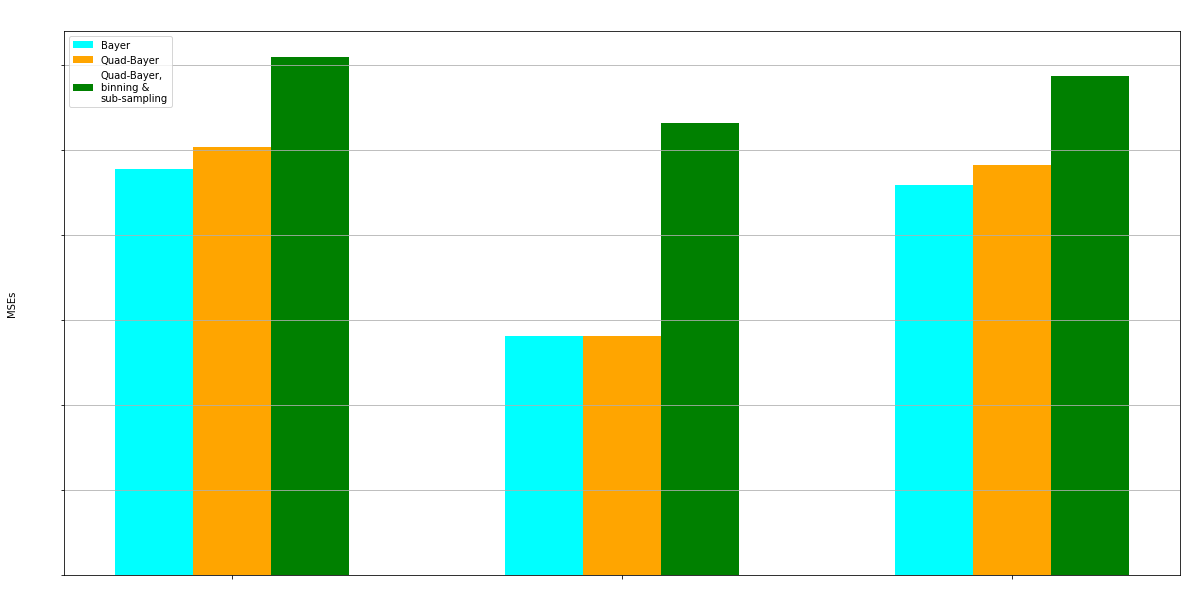

In [11]:
Ux_hat_Bayer_errors = errors(Ux, Ux_hat_Bayer)
Ux_hat_Quad_errors = errors(Ux, Ux_hat_Quad)
Ux_hat_up_errors = errors(Ux, Ux_hat_up)

plot_errors([Ux_hat_Bayer_errors, Ux_hat_Quad_errors, Ux_hat_up_errors])

## II.4) Visualization

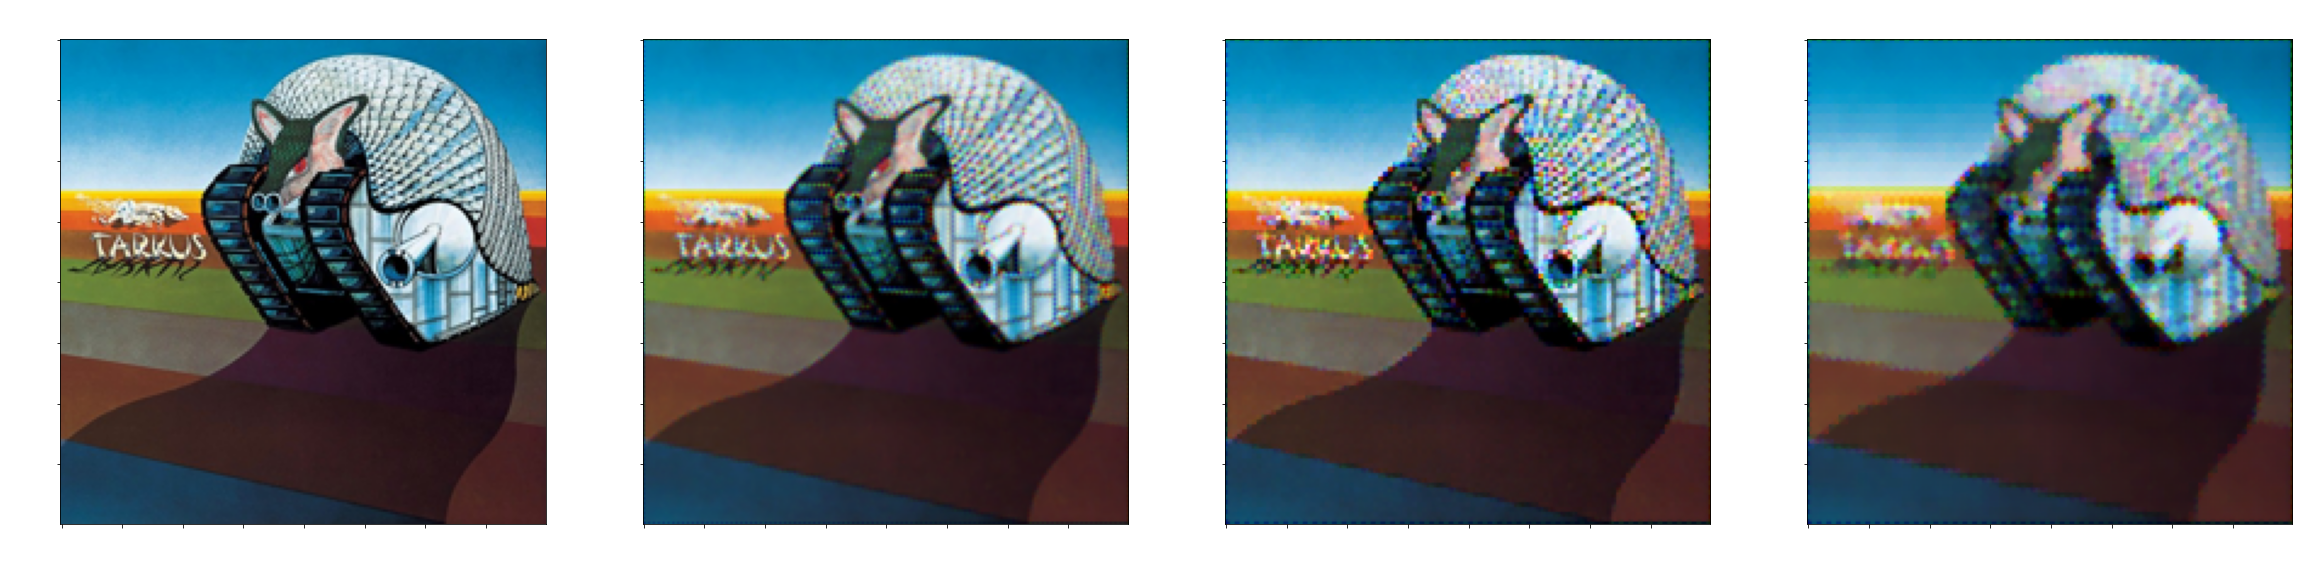

In [12]:
plot_images([Ux, Ux_hat_Bayer, Ux_hat_Quad, Ux_hat_up], ['Input image Ux', 'Reconstructed image Ux_hat_Bayer', 'Reconstructed image Ux_hat_Quad', 'Reconstructed image Ux_hat_up'])